In [64]:
%load_ext autoreload
%autoreload 2

from spyglass.spikesorting.v0 import CuratedSpikeSorting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spyglass.common import interval_list_contains, PositionIntervalMap, TaskEpoch

import os

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from ms_opto_stim_protocol import OptoStimProtocol
from spyglass.common import convert_epoch_interval_name_to_position_interval_name

import matplotlib.pyplot as plt
import os

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from Analysis.spiking_analysis import smooth
from Analysis.position_analysis import get_running_intervals
from Analysis.utils import filter_opto_data, get_running_valid_intervals,violin_scatter
from Analysis.spiking_autocorrelegram import autocorrelegram,plot_periodicity_dependence
from Style.style_guide import interval_style, animal_style

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# import os
# os.path.exists('./Plots/gm_20240227/')

True

# Open Loop

datasets: 2
linear_limits [10, 126.8923664781934]


[2024-04-15 12:00:11,908][WARNING]: Skipped checksum for file with hash: f5118d6f-feeb-70ef-73da-912dd48edd6e, and path: /stelmo/nwb/raw/Totoro20220602_.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace

linear_limits [10, 126.8923664781934]


[2024-04-15 12:00:31,514][WARNING]: Skipped checksum for file with hash: 43b9576d-481d-6c4d-0cbd-9badac7128f2, and path: /stelmo/nwb/raw/Totoro20220603_.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace

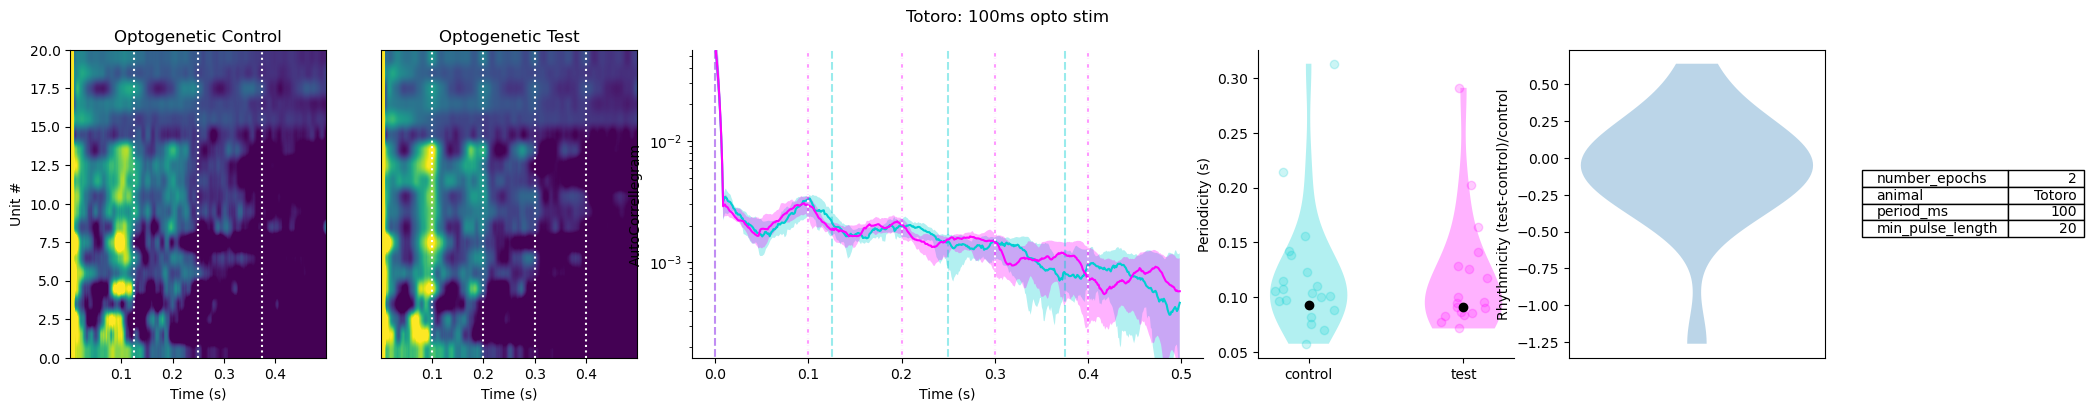

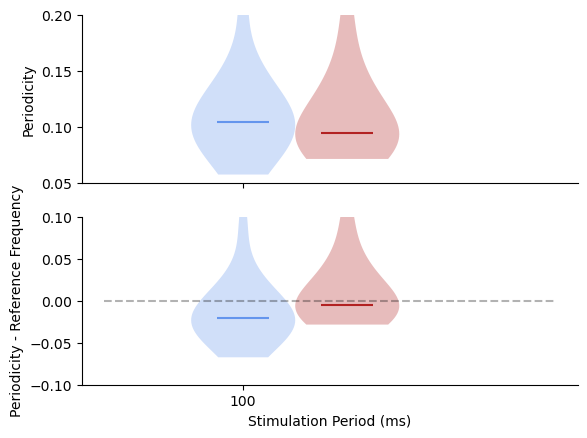

In [2]:
from Analysis.spiking_autocorrelegram import autocorrelegram,plot_periodicity_dependence
plt.rcParams['svg.fonttype'] = 'none'
period = 50
animal = "Totoro"
min_spikes = 300
periods = [250,165,125,100,80,50]
periods = [100]
periodicities = []
for period in periods:
    dataset_key = {"animal":animal,
                "period_ms":period,
                "min_pulse_length":20,
                #    "targeted_phase":90
                }
    fig, periodicity, autocorr = autocorrelegram(dataset_key, return_periodicity_results=True,
                                                 return_auto_corr=True)
    periodicities.append(periodicity)
    # fig.savefig(f"./Plots/gm_20240227/autocorrelogram_{animal}_{period}.svg")
    # fig.savefig(f"./Plots/gm_20240227/autocorrelogram_{animal}_{period}.pdf")
    
    break
fig_periodicity = plot_periodicity_dependence(periodicities, periods)
# fig_periodicity.savefig(f"./Plots/gm_20240227/autocorrelogram_periodicity_dependence_{animal}.svg")
# fig_periodicity.savefig(f"./Plots/gm_20240227/autocorrelogram_periodicity_dependence_{animal}.pdf")

## Abhilasha paper method

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f4077c72fd0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f4077c72220>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f4077c72cd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f4077c72370>}

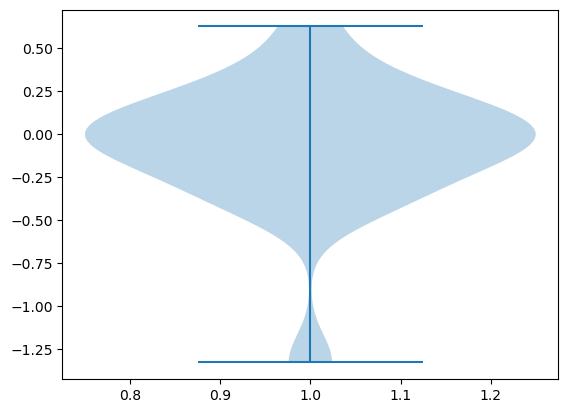

In [113]:
autocorr[0].shape




rhythm = [rhythmicity(data) for data in autocorr]
rhythm  = (rhythm[1]-rhythm[0])/rhythm[0]
plt.violinplot(rhythm)
# plt.scatter(np.ones(len(rhythm[0])),rhythm[0])
# plt.scatter(np.ones(len(rhythm[1]))*2,rhythm[1])

# for x1,x2 in zip(rhythm[0],rhythm[1]):
#     plt.plot([1,2],[x1,x2],color='black',alpha=0.1)

## fft method

In [111]:
def analyze_rhythmicity(x, tau, freq_range):
    # Calculate the sampling frequency
    sampling_interval = np.mean(np.diff(tau))
    
    # Apply Fourier Transform to the autocorrelation series
    power_spectrum = np.abs(np.fft.fft(x)) ** 2
    frequencies = np.fft.fftfreq(x.size, d=sampling_interval)
    
    # Ensure positive frequencies and corresponding power spectrum
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_power_spectrum = power_spectrum[:len(power_spectrum)//2]
    
    # Identify the index range for the specified frequency range
    freq_index = np.where((positive_frequencies >= freq_range[0]) & (positive_frequencies <= freq_range[1]))[0]
    
    # Find the peak frequency within the specified range
    peak_index = np.argmax(positive_power_spectrum[freq_index])
    peak_frequency = positive_frequencies[freq_index][peak_index]
    peak_power = positive_power_spectrum[freq_index][peak_index]
    
    print(f"Peak Frequency: {peak_frequency} Hz")
    
    # Return the power amplitude of the peak frequency
    return peak_power,positive_power_spectrum, positive_frequencies

from scipy.signal import welch
def analyze_rhythmicity_with_welch(x, tau, freq_range, nperseg=None):
    # Calculate the sampling frequency
    sampling_interval = tau[1] - tau[0]
    fs = 1 / sampling_interval
    
    # Use Welch's method to compute the power spectral density
    frequencies, power_spectrum = welch(x, fs=fs, nperseg=nperseg, scaling='spectrum',nfft=10000)
    
    # Identify the index range for the specified frequency range
    freq_index = np.where((frequencies >= freq_range[0]) & (frequencies <= freq_range[1]))[0]
    
    # Find the peak frequency within the specified range
    peak_index = np.argmax(power_spectrum[freq_index])
    peak_frequency = frequencies[freq_index][peak_index]
    peak_power = power_spectrum[freq_index][peak_index]
    
    print(f"Peak Frequency: {peak_frequency} Hz")
    
    # Return the power amplitude of the peak frequency
    return peak_power, power_spectrum, frequencies

# Closed Loop

datasets: 2
linear_limits [10, 126.8923664781934]


[2024-04-22 15:03:36,962][WARNING]: Skipped checksum for file with hash: 1fb4cf78-9ee6-df68-2734-4b3c6f0f8e42, and path: /stelmo/nwb/raw/Yoshi20220513_.nwb


linear_limits [10, 126.8923664781934]


[2024-04-22 15:03:46,564][WARNING]: Skipped checksum for file with hash: 1fb4cf78-9ee6-df68-2734-4b3c6f0f8e42, and path: /stelmo/nwb/raw/Yoshi20220513_.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(-0.02, 1.2)

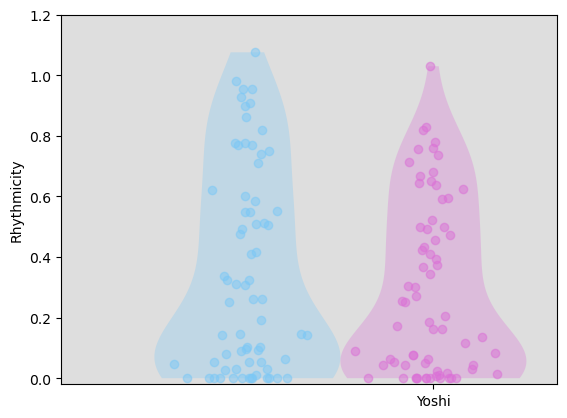

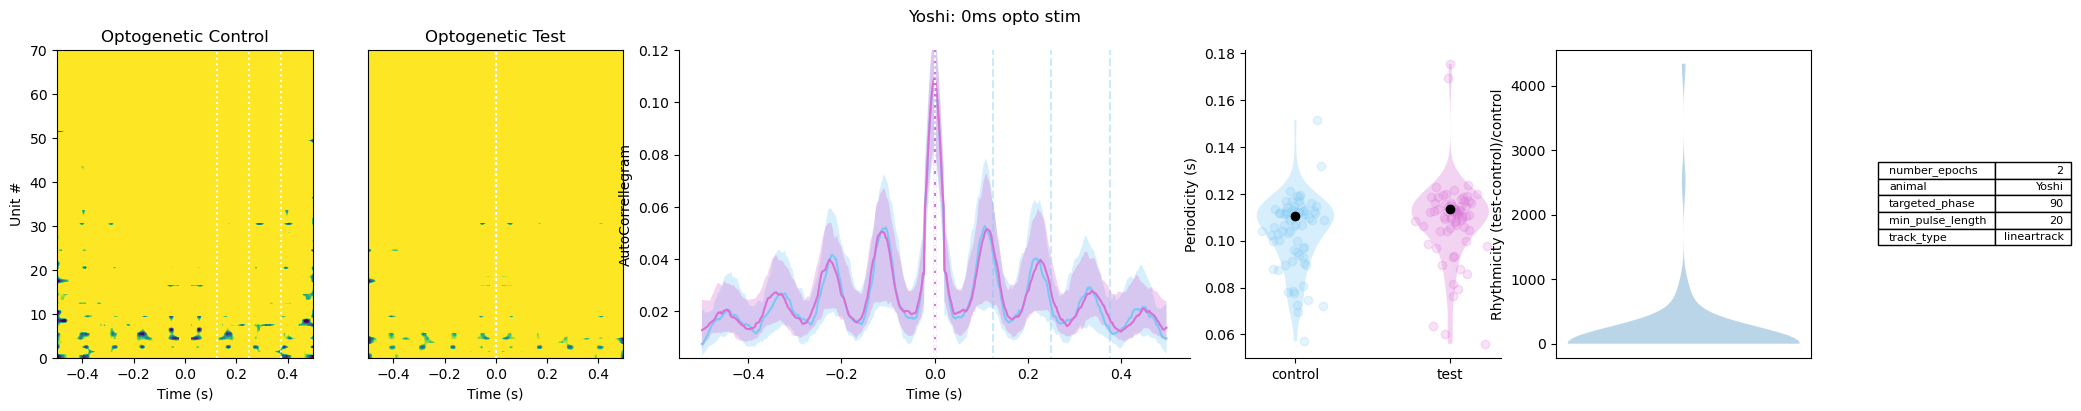

In [94]:


animal_list = ["Winnie", "Frodo", "Totoro", "Olive", "Yoshi"]
# animal_list = ["Winnie","Yoshi"]
animal_list = ["Winnie",]# "Yoshi"]
fig_rhythm = plt.figure()
rhythm_list = {}
for i, animal in enumerate(animal_list):
    dataset_key = {
        "animal": animal,
        "targeted_phase": 90,
        "min_pulse_length": 20,
        "track_type": "lineartrack",  # lineartrack"
    }
    fig, periodicity, autocorr = autocorrelegram(
        dataset_key,
        return_periodicity_results=True,
        return_auto_corr=True,
        linear_detrend=False,
    )
    if not len(periodicity[0]):
        continue
    for ii, color in enumerate([interval_style["control"], interval_style["test"]]):
        violin_scatter(
            periodicity[-2][ii],
            i + ii * 0.3,
            ax=fig_rhythm.gca(),
            color=color,
            widths=0.3,
        )
        lower = -0.02
        upper = 1.2
        fig_rhythm.gca().fill_between(
            [i - 0.3, i + 0.7],
            [lower, lower],
            [upper, upper],
            facecolor=animal_style.loc[animal, "color"],
            alpha=0.3,
            zorder=-1,
        )
    fig.savefig(f"/home/sambray/Pictures/Fig_2/autocorrelogram_{animal}.svg")

# fig_rhythm.gca().plot(
#     [-0.5, len(animal_list) - 0.5], [0, 0], color="grey", linestyle="--"
# )
fig_rhythm.gca().set_xticks(np.arange(len(animal_list)) + 0.3, animal_list)
fig_rhythm.gca().set_ylabel("Rhythmicity")
fig_rhythm.gca().set_xlim([-0.3, len(animal_list) - 0.5])
fig_rhythm.gca().set_ylim(lower, upper)

In [90]:
fig_rhythm.savefig("/home/sambray/Pictures/Fig_2/autocorrelogram_rhythmicity.svg")